# Football Manager 2024 - Player Valuation Analysis

An attempt to model player valuation based on their attributes to find undervalued attributes.

### Data Loading

In [57]:
import pandas as pd
import numpy as np
import datetime as dt

file = "prem player export.rtf"
df = pd.read_csv(file, delimiter="|")

### Data Pre-Processing

In [58]:
df = df.rename(columns=str.strip) #stripping column names
df.dropna(subset=["Height"], inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Strip spaces, and convert wage to a float
df["Wage"] = df["Wage"].str.strip()
df["Wage"] = df["Wage"].str.replace("£", "", regex=True)
df["Wage"] = df["Wage"].str.replace(",", "", regex=True)
df["Wage"] = df["Wage"].str.replace(" p/w", "", regex=True)
df["Wage"] = df["Wage"].astype(float)

# Handling the string for transfer value and creating an average float value between min and max estimate.
df[["Min Value", "Max Value"]] = df["Transfer Value"].str.split(" - ", expand=True)
df["Min Value"] = df["Min Value"].str.strip().str.replace("£", "")
df["Min Value"] = df["Min Value"].replace("Not for Sale", np.nan)
df["Max Value"] = df["Max Value"].str.strip().str.replace("£", "")

def convert_values(value):
    if pd.isna(value):
        return np.nan
    elif "M" in value:
        return float(value.replace("M", "")) * 1000000
    elif "K" in value:
        return float(value.replace("K", "")) * 1000
    else:
        return float(value)
    
df["Min Value"] = df["Min Value"].apply(convert_values)
df["Max Value"] = df["Max Value"].apply(convert_values)
df["Avg Value"] = (df["Min Value"] + df["Max Value"]) / 2

# Converting the height data into cm
df[["height_feet", "height_inch"]]= pd.DataFrame(df["Height"].str.strip().str.replace('"', "").str.split("'").to_list(), index=df.index).astype(int)
df["height_cm"] = (((df["height_feet"] * 12) + (df["height_inch"])) * 2.54).astype(float)


# Converting the contract expiry date into years remaining
start_date = dt.datetime.strptime('2023-09-01', "%Y-%m-%d")
df["Expires"] = pd.to_datetime(df["Expires"], dayfirst=True)
df["Months Remaining"] = round(((df["Expires"] - start_date).dt.days / 30.4375),0)


# Drop any rows will nulls.
df = df.dropna()


# Outputting the cleansed data to csv for checking
df.to_csv("output.csv")

### Exploratory Data Analysis

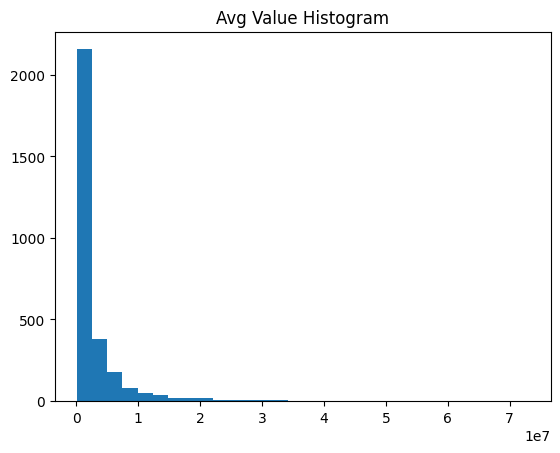

In [59]:
import matplotlib.pyplot as plt

plt.hist(df["Avg Value"], bins=30)
plt.title("Avg Value Histogram")
plt.show()

As you can see, the target variable is heavily right skewed. Therefore, I will apply a log transformation.

count    2975.000000
mean       14.198062
std         1.090085
min        12.206078
25%        13.399997
50%        14.006132
75%        14.884514
max        18.105970
Name: Log Avg Value, dtype: float64


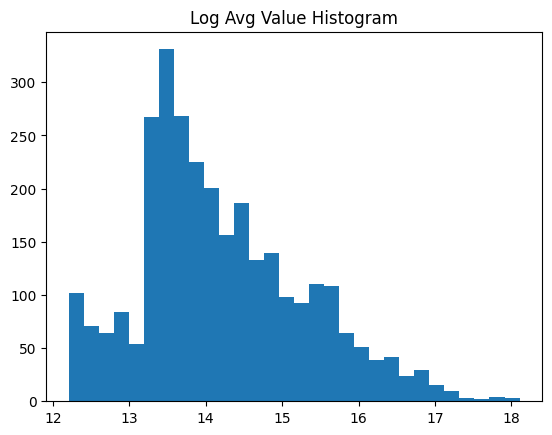

In [60]:
df["Log Avg Value"] = np.log1p(df["Avg Value"])
print(df["Log Avg Value"].describe())
plt.hist(df["Log Avg Value"], bins=30)
plt.title("Log Avg Value Histogram")
plt.show()

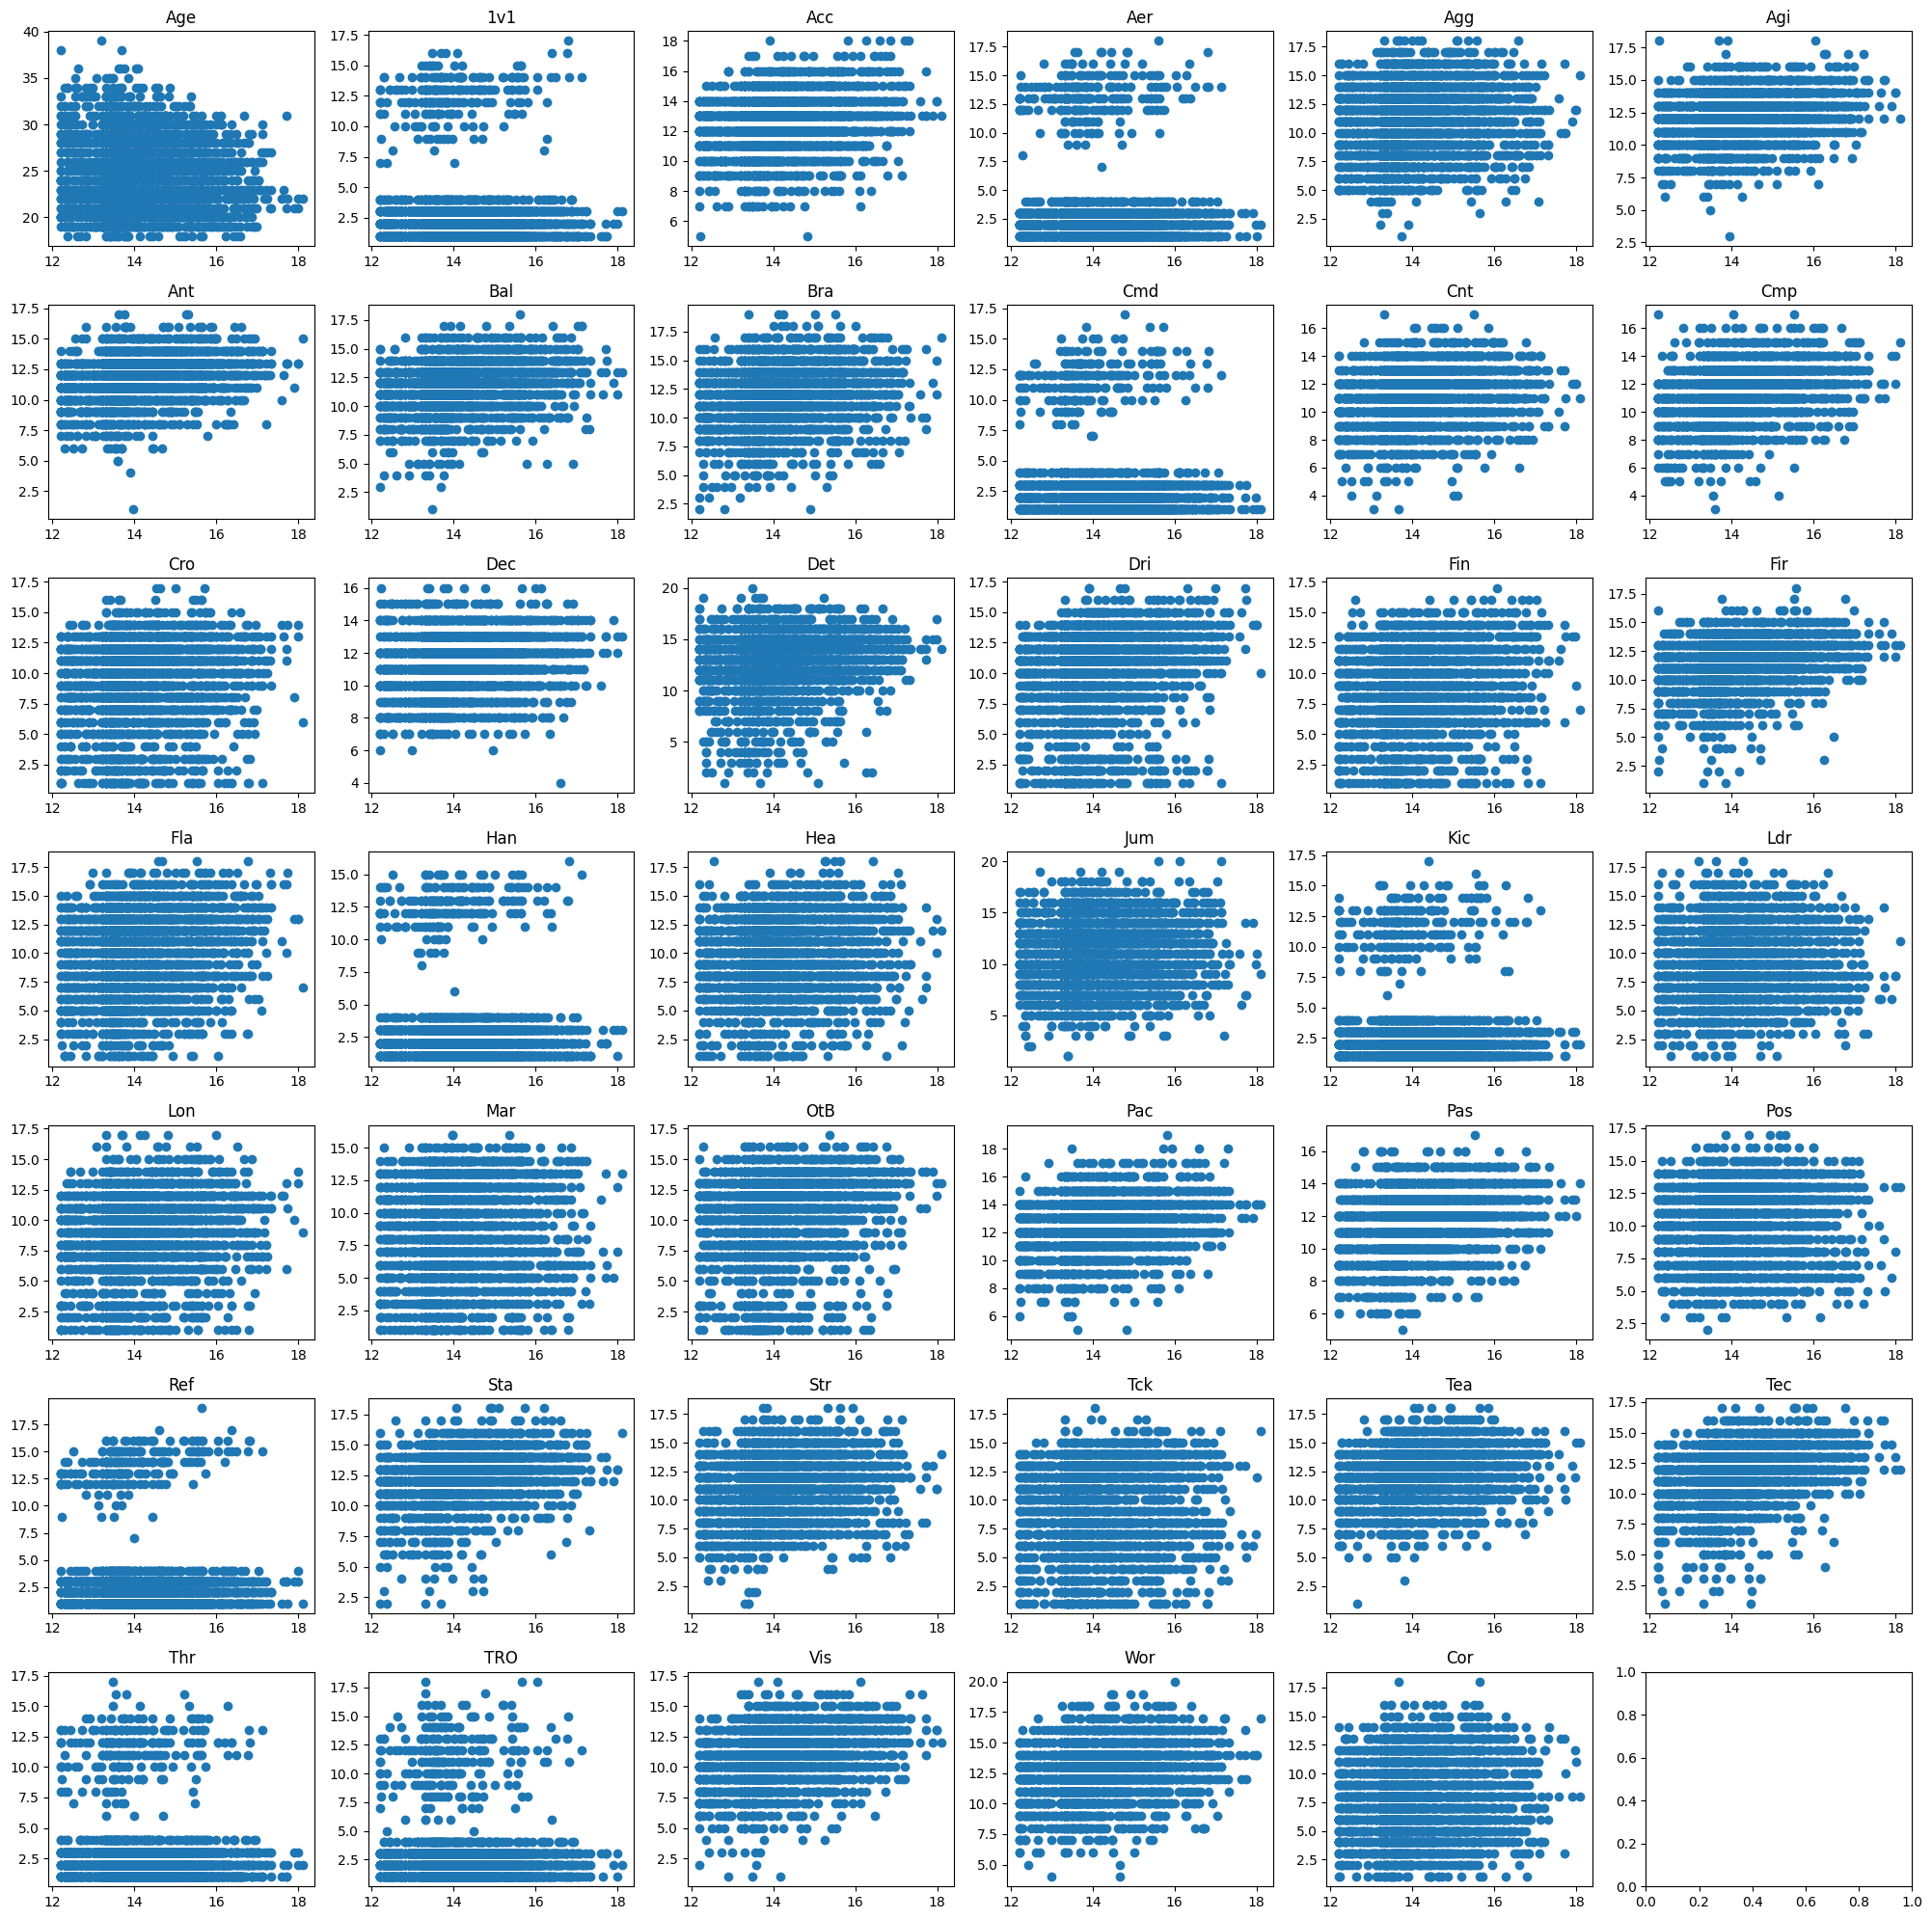

In [61]:
n_rows, n_cols = 7, 6

columns = ["Age", "1v1", "Acc", "Aer", "Agg", "Agi", "Ant", "Bal", "Bra", "Cmd", "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla", "Han", "Hea", "Jum", "Kic", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Ref", "Sta", "Str", "Tck", "Tea", "Tec", "Thr", "TRO", "Vis",
               "Wor", "Cor"]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes = axes.flatten()

for i, col in enumerate(columns):
    axes[i].scatter(df["Log Avg Value"], df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

As you can see from above, a clear insight to take from this is that the GK attributes are messing up everying else. The decision here should be to separate the model into a GK and an outfield model.

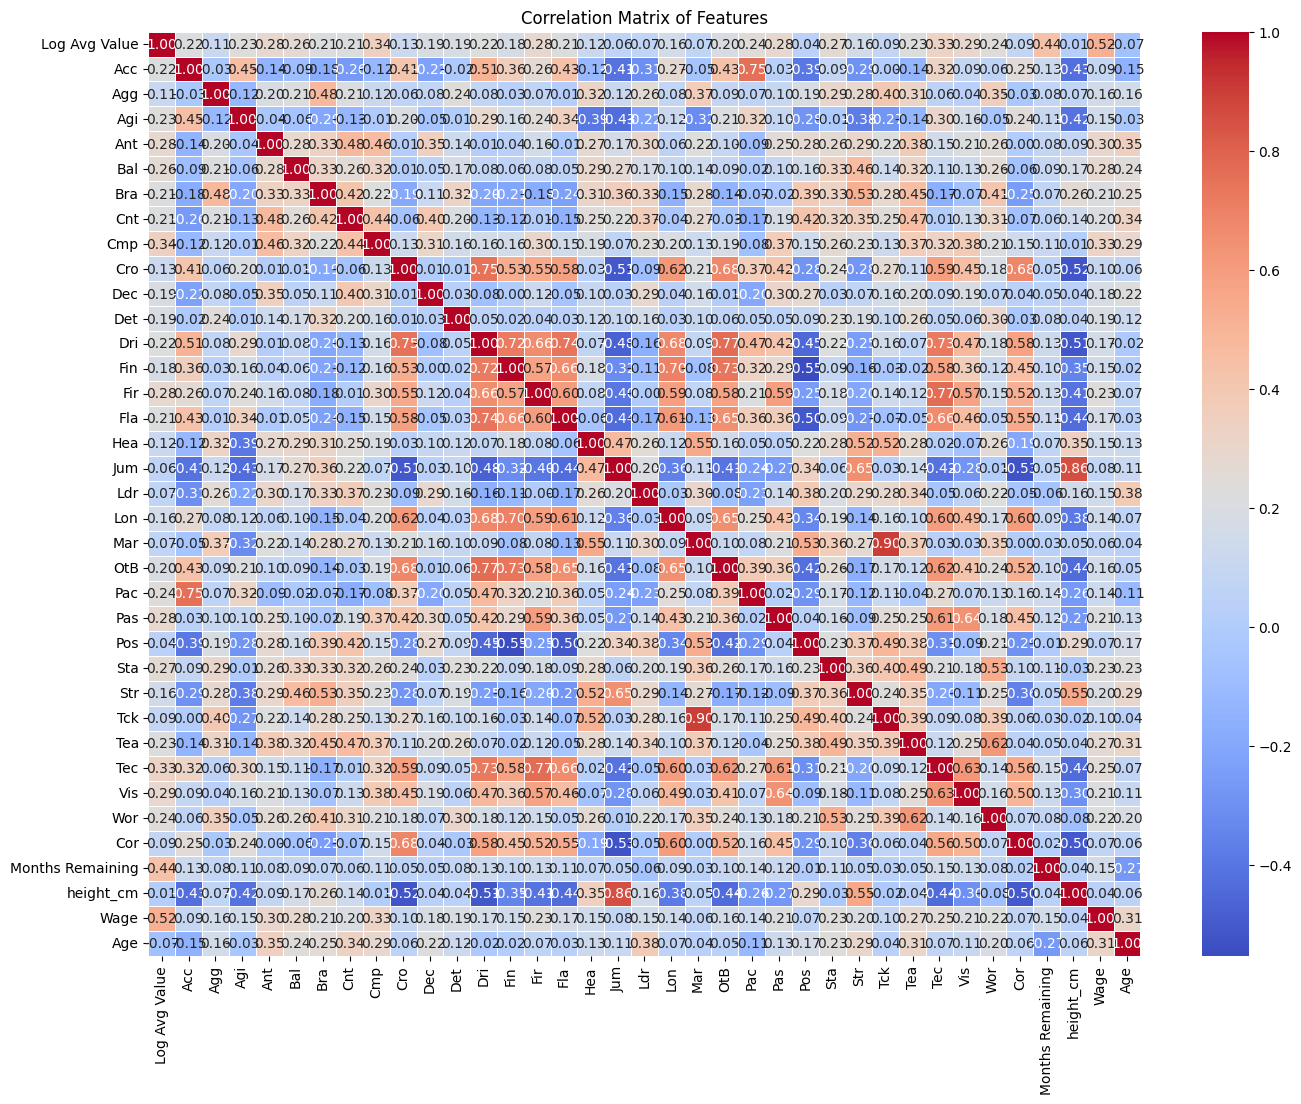

In [62]:
import seaborn as sns

corr_matrix = df[["Log Avg Value", "Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age"]].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Features")
plt.show()

I wouldn't say there are any bib issues with the correlation matrix, however one insight is that some features could be merged, particularly the features that have a corr score of > 0.8.

### Feature Engineering

In [63]:
# Merging attributes into features that represent training groups.

df["Aerial ability"] = (df["height_cm"] + df["Jum"]).mean()
df["Defensive Ability"] = (df["Tck"] + df["Mar"]).mean()


In [64]:
# Maybe try features for reputation and top 5 league?



from sklearn.preprocessing import StandardScaler


# Currently I am filtering out GK players and GK attributes from the model.
df = df[~df["Position"].str.contains("GK")]
X_outfield = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age"]]

X_outfield_merged = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Ldr", "Lon",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Aerial ability", "Defensive Ability",  "Months Remaining", "Wage", "Age"]]





### Model Building

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Testing the model for all attribute features

y = df["Log Avg Value"]
scaler = StandardScaler()
X_outfield_scaled = scaler.fit_transform(X_outfield)

X_train, X_test, y_train, y_test = train_test_split(X_outfield_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"r2: {r2}")
print(f"mse: {mse}")

r2: 0.5817661909048282
mse: 0.49706231443976423


In [66]:
# Testing the model with merged attributes features.

y = df["Log Avg Value"]
scaler = StandardScaler()
X_outfield_scaled = scaler.fit_transform(X_outfield_merged)

X_train, X_test, y_train, y_test = train_test_split(X_outfield_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"r2: {r2}")
print(f"mse: {mse}")

r2: 0.5759749485617808
mse: 0.5039450873287958


As you can see from above, the model peforms margainly worse when using the feature set of merged attributes.

In [67]:
coefficients = model.coef_

coef_df = pd.DataFrame({
    "Feature": X_outfield_merged.columns,
    "Coefficient": coefficients
})

coef_df.sort_values("Coefficient", ascending=False, inplace=True)

print(coef_df)

              Feature   Coefficient
32               Wage  3.728137e-01
31   Months Remaining  1.760673e-01
0                 Acc  1.606176e-01
25                Tec  1.231310e-01
23                Str  1.119215e-01
7                 Cmp  1.046405e-01
9                 Dec  1.016279e-01
19                Pac  9.740488e-02
15                Hea  9.084628e-02
16                Ldr  8.406795e-02
22                Sta  8.125273e-02
27                Wor  8.001793e-02
5                 Bra  6.919593e-02
26                Vis  6.776857e-02
3                 Ant  6.374620e-02
12                Fin  6.120224e-02
2                 Agi  6.013546e-02
10                Det  3.648562e-02
21                Pos  3.360786e-02
4                 Bal  3.349108e-02
13                Fir  3.151931e-02
20                Pas  2.972219e-02
14                Fla  2.711193e-02
6                 Cnt  2.689797e-02
8                 Cro  2.187417e-02
17                Lon  1.268519e-02
28                Cor  2.557